# 02 — Hidráulica del sistema: $Q \to V$, cavitación (screening), transientes (proxy) y ML orientado a física

## Objetivo
Con datos de presión y caudal muestreados a $\Delta t \approx 1$ min, este notebook construye variables hidráulicas y pruebas cuantitativas que **sí** se pueden hacer con este muestreo:

1. Conversión $Q \to V$ usando el diámetro $D$
2. Conversión a presión absoluta (porque la presión medida es manométrica)
3. **Screening de cavitación** por condición $P_{abs} < P_v(T)$ y por número de cavitación $\sigma$
4. Proxy de transientes: relación $\Delta P$–$\Delta V$ y estimación de $a_{\mathrm{ef}}$ (con cautela por submuestreo)
5. Extracción de **episodios** (eventos agrupados) y **ML** (clustering/anomalías) sobre features físicas

> Nota de escala: con muestreo a 1 minuto, transientes de segundos pueden quedar submuestreados. Aquí se estudian “huellas” a escala minuto: escalones, rampas, colapsos y cambios de régimen.


In [49]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

PROJECT_ROOT = Path('/home/maxi/datascience_esval')
CLEAN_FILE = PROJECT_ROOT / 'data' / 'processed' / 'sensores_1min_clean.parquet'

OUT_EPISODES = PROJECT_ROOT / 'data' / 'processed' / 'episodios_hidraulicos.parquet'
OUT_FEATURES = PROJECT_ROOT / 'data' / 'processed' / 'features_episodios_hidraulicos.parquet'

CLEAN_FILE.exists(), CLEAN_FILE


(True,
 PosixPath('/home/maxi/datascience_esval/data/processed/sensores_1min_clean.parquet'))

## 1) Carga del dataset (1-min, limpio)

In [50]:
g = pd.read_parquet(CLEAN_FILE)
g.index = pd.to_datetime(g.index)
g = g.sort_index()
g.index.name = 't'

P_COL = 'p_bar'            # presión manométrica (gauge) [bar]
Q_COL = 'q_lps'            # caudal [L/s]
dP_COL = 'dP_bar_clean'    # ΔP limpio [bar/min]
dQ_COL = 'dQ_lps_clean'    # ΔQ limpio [L/s/min]
MISS_COL = 'is_missing_any'

g.shape, g.index.min(), g.index.max(), g.columns.tolist()


((475201, 9),
 Timestamp('2025-01-01 00:00:00'),
 Timestamp('2025-11-27 00:00:00'),
 ['p_bar',
  'q_lps',
  'dP_bar_clean',
  'dQ_lps_clean',
  'is_missing_p',
  'is_missing_q',
  'is_missing_any',
  'gap_len_min',
  'is_q_at_max'])

## 2) Parámetros físicos (ajustables)

- Diámetro: $$D = 315\,\mathrm{mm} = 0.315\,\mathrm{m}$$
- Área: $$A = \frac{\pi D^2}{4}$$
- Densidad del fluido: $$\rho_f \approx 1000\ \mathrm{kg/m^3}$$
- Presión atmosférica: $$P_{atm}\approx 1.01325\ \mathrm{bar}$$ (ajustable por altitud)
- Temperatura: $T$ (para $P_v(T)$); por defecto 20°C

> Si conoces altitud/temperatura real, cambia estos valores.


In [51]:
# --- Parámetros del sistema ---
D = 0.315  # m
A = np.pi * (D**2) / 4  # m^2

rho_f = 1000.0   # kg/m3 (aprox)
P_atm_bar = 1.01325  # bar (ajustable por altitud)
T_C = 20.0       # °C (ajustable)

A


0.07793113276311181

## 3) Presión absoluta y cavitación (screening)

### Presión absoluta
Como el sensor mide presión manométrica:
$$
P_{abs}(t) \approx P_g(t) + P_{atm}
$$

### Cavitación termodinámica
Condición:
$$
P_{abs}(t) < P_v(T)
$$
donde $P_v(T)$ es la presión de vapor del agua a temperatura $T$.

### Número de cavitación
Indicador hidráulico útil:
$$
\sigma = \frac{P_{abs}-P_v(T)}{\tfrac{1}{2}\rho_f V^2}
$$

Valores bajos de $\sigma$ sugieren mayor susceptibilidad a cavitación local (especialmente cerca de singularidades).


## 4) Funciones: presión de vapor del agua $P_v(T)$

Usamos una aproximación tipo Antoine (válida como **screening** en rango moderado de temperaturas).
Devuelve $P_v$ en Pa y en bar.


In [52]:
def pvap_water_pa(T_C: float) -> float:
    """Presión de vapor del agua [Pa] usando Antoine (aprox).
    Válida de forma razonable para ~1–100°C (screening).
    """
    # Antoine (agua): log10(P_mmHg) = A - B/(C+T)
    A_, B_, C_ = 8.07131, 1730.63, 233.426  # para 1–100°C
    P_mmHg = 10 ** (A_ - (B_ / (C_ + T_C)))
    return float(P_mmHg * 133.322)  # mmHg -> Pa

def pa_to_bar(P_pa: float) -> float:
    return float(P_pa / 1e5)

Pv_pa = pvap_water_pa(T_C)
Pv_bar = pa_to_bar(Pv_pa)

Pv_pa, Pv_bar


(2329.5689144226494, 0.023295689144226493)

## 5) Variables hidráulicas: $Q\to V$, $P_g\to P_{abs}$

Convertimos:
- $Q$ [L/s] $\to$ [m³/s]
- $V = Q/A$ [m/s]
- $P_{abs} = P_g + P_{atm}$ [bar]
- margen a vapor: $P_{abs}-P_v(T)$

Luego calculamos el número de cavitación $\sigma$.


In [53]:
h = g.copy()

valid = (~h[MISS_COL]) & h[P_COL].notna() & h[Q_COL].notna()
h['is_valid'] = valid

h['q_m3s'] = h[Q_COL] / 1000.0
h['v_ms'] = h['q_m3s'] / A

h['p_g_bar'] = h[P_COL]
h['p_abs_bar'] = h['p_g_bar'] + P_atm_bar

h['pv_bar'] = Pv_bar
h['margin_vap_bar'] = h['p_abs_bar'] - h['pv_bar']  # >0 => por encima de Pv

# σ = (Pabs - Pv) / (0.5 rho V^2) usando Pa
h['margin_vap_pa'] = h['margin_vap_bar'] * 1e5
h['dyn_pa'] = 0.5 * rho_f * (h['v_ms']**2)
h['sigma_cav'] = h['margin_vap_pa'] / h['dyn_pa']

display(h.loc[h['is_valid'], ['p_g_bar','p_abs_bar','q_m3s','v_ms','margin_vap_bar','sigma_cav']]
        .describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).T)


/home/maxi/datascience_esval/venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,1%,5%,50%,95%,99%,max
p_g_bar,462130.0,1.463275,0.264075,0.000000,0.917255,0.971270,1.520423,1.829509,1.981551,2.203613
p_abs_bar,462130.0,2.476525,0.264075,1.013250,1.930505,1.984520,2.533673,2.842759,2.994801,3.216863
q_m3s,462130.0,0.049498,0.019536,0.000000,0.016770,0.019270,0.050190,0.080250,0.089470,0.099000
v_ms,462130.0,0.635147,0.250680,0.000000,0.215190,0.247270,0.644030,1.029755,1.148065,1.270352
margin_vap_bar,462130.0,2.453230,0.264075,0.989954,1.907210,1.961225,2.510377,2.819463,2.971506,3.193567
sigma_cav,462130.0,inf,NaN,123.533544,341.397205,453.671497,1263.120382,6620.867247,8620.704484,inf


## 6) Distribución de velocidades y escala dinámica

Mostramos percentiles de $V$ y de la presión dinámica $\tfrac{1}{2}\rho_f V^2$.


V (m/s) percentiles:
count    462130.000000
mean          0.635147
std           0.250680
min           0.000000
1%            0.215190
5%            0.247270
50%           0.644030
95%           1.029755
99%           1.148065
99.9%         1.262782
max           1.270352
Name: v_ms, dtype: float64


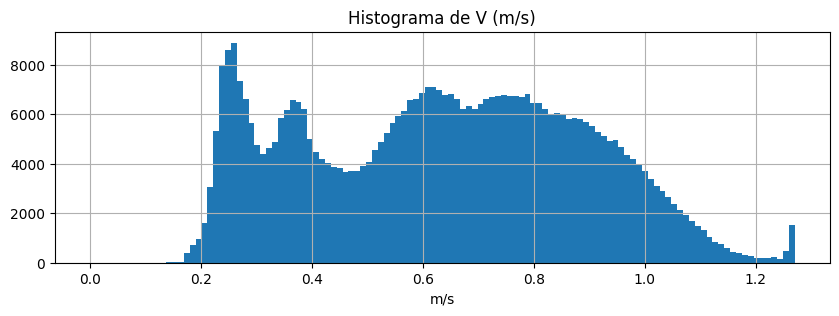

Presión dinámica 0.5*rho*V^2 (Pa) percentiles:
count    462130.000000
mean        233.125881
std         163.696436
min           0.000000
50%         207.387424
90%         465.073474
95%         530.198029
99%         659.026535
99.9%       797.308676
max         806.897585
Name: dyn_pa, dtype: float64


In [54]:
v = h.loc[h['is_valid'], 'v_ms'].dropna()

print('V (m/s) percentiles:')
print(v.describe(percentiles=[0.01,0.05,0.5,0.95,0.99,0.999]))

plt.figure(figsize=(10,3))
plt.hist(v, bins=120)
plt.title('Histograma de V (m/s)')
plt.xlabel('m/s')
plt.show()

dyn = h.loc[h['is_valid'], 'dyn_pa'].dropna()
print('Presión dinámica 0.5*rho*V^2 (Pa) percentiles:')
print(dyn.describe(percentiles=[0.5,0.9,0.95,0.99,0.999]))


## 7) Cavitación — screening por $P_{abs} < P_v(T)$

Aquí evaluamos si, en el punto del sensor, existe alguna muestra con:
$$
P_{abs}(t) < P_v(T)
$$
y revisamos percentiles del margen $P_{abs}-P_v(T)$ y de $\sigma$.


In [55]:
vv = h[h['is_valid']].copy()

vv['is_cav_thermo'] = vv['p_abs_bar'] < vv['pv_bar']

print('Pv(T) [bar] =', Pv_bar, 'con T_C =', T_C)
print('Min p_abs_bar =', float(vv['p_abs_bar'].min()))
print('Frac(p_abs < Pv) =', float(vv['is_cav_thermo'].mean()))
print('N minutos con p_abs < Pv =', int(vv['is_cav_thermo'].sum()))

print('\nPercentiles de margen (p_abs - Pv) [bar]:')
print(vv['margin_vap_bar'].describe(percentiles=[0.001,0.01,0.05,0.5,0.95,0.99,0.999]))

print('\nPercentiles sigma_cav:')
sig = vv['sigma_cav'].replace([np.inf,-np.inf], np.nan).dropna()
print(sig.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))


Pv(T) [bar] = 0.023295689144226493 con T_C = 20.0
Min p_abs_bar = 1.01325
Frac(p_abs < Pv) = 0.0
N minutos con p_abs < Pv = 0

Percentiles de margen (p_abs - Pv) [bar]:
count    462130.000000
mean          2.453230
std           0.264075
min           0.989954
0.1%          1.268161
1%            1.907210
5%            1.961225
50%           2.510377
95%           2.819463
99%           2.971506
99.9%         3.011517
max           3.193567
Name: margin_vap_bar, dtype: float64

Percentiles sigma_cav:
count    462124.000000
mean       2131.694532
std        2070.797600
min         123.533544
1%          341.396454
5%          453.670750
50%        1263.103264
95%        6620.677336
99%        8618.935045
max       20361.022272
Name: sigma_cav, dtype: float64


### Sensibilidad: $P_{atm}$ y $T$

Se explora sensibilidad simple variando:
- $P_{atm}$ entre 0.85–1.02 bar
- $T$ entre 10–30 °C


In [56]:
P_atm_grid = [0.85, 0.90, 0.95, 1.01325]
T_grid = [10.0, 20.0, 30.0]

rows = []
p_g = vv['p_g_bar'].values

for Patm in P_atm_grid:
    for Tc in T_grid:
        Pv_b = pa_to_bar(pvap_water_pa(Tc))
        p_abs = p_g + Patm
        frac_cav = float(np.mean(p_abs < Pv_b))
        rows.append({
            'P_atm_bar': Patm,
            'T_C': Tc,
            'Pv_bar': Pv_b,
            'min_p_abs_bar': float(np.nanmin(p_abs)),
            'frac(p_abs<Pv)': frac_cav
        })

sens = pd.DataFrame(rows)
sens


,P_atm_bar,T_C,Pv_bar,min_p_abs_bar,frac(p_abs<Pv)
0,0.85000,10.0,0.012211,0.85000,0.0
1,0.85000,20.0,0.023296,0.85000,0.0
2,0.85000,30.0,0.042317,0.85000,0.0
3,0.90000,10.0,0.012211,0.90000,0.0
4,0.90000,20.0,0.023296,0.90000,0.0
5,0.90000,30.0,0.042317,0.90000,0.0
6,0.95000,10.0,0.012211,0.95000,0.0
7,0.95000,20.0,0.023296,0.95000,0.0
8,0.95000,30.0,0.042317,0.95000,0.0
9,1.01325,10.0,0.012211,1.01325,0.0


## 8) Transientes (proxy): $\Delta Q\to \Delta V$ y relación $\Delta P$–$\Delta V$

Con $A$ conocida:
$$
\Delta V = \frac{\Delta Q}{A}
$$

y (aprox. Joukowsky):
$$
\Delta P \approx \rho_f\, a\, \Delta V
$$

Como el muestreo es a 1 minuto, definimos un proxy:
- $\Delta P$ y $\Delta V$ a escala minuto (puede subestimar picos reales)
- estimación “efectiva”:
$$
a_{\mathrm{ef}} = \frac{\Delta P}{\rho_f\,\Delta V}\quad (\Delta V\neq 0)
$$


Percentiles |dV| (m/s por min):
count    460173.000000
mean          0.011748
std           0.024273
min           0.000000
50%           0.006801
90%           0.022969
95%           0.030027
99%           0.108301
99.9%         0.294854
max           1.058627
Name: dV_ms, dtype: float64

Percentiles |dP| (bar por min):
count    460173.000000
mean          0.022482
std           0.033744
min           0.000000
50%           0.016004
90%           0.044012
95%           0.056016
99%           0.123314
99.9%         0.421117
max           1.534427
Name: dP_bar_clean, dtype: float64

Resumen a_eff (m/s) [proxy]:
count    443216.000000
mean       -106.532099
std         837.040673
min       -4988.980544
1%        -3118.112840
5%        -1280.653488
50%         -95.064416
95%        1023.130776
99%        2944.884349
max        4988.980544
Name: a_eff_ms, dtype: float64


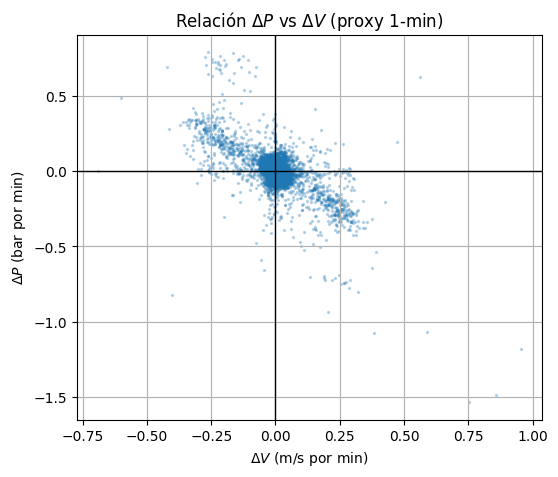

In [57]:
vv['dQ_m3s'] = vv[dQ_COL] / 1000.0
vv['dV_ms'] = vv['dQ_m3s'] / A

vv['dP_pa'] = vv[dP_COL] * 1e5

eps = 1e-6
mask = vv['dV_ms'].abs() > eps
vv['a_eff_ms'] = np.where(mask, vv['dP_pa'] / (rho_f * vv['dV_ms']), np.nan)

print('Percentiles |dV| (m/s por min):')
print(vv['dV_ms'].abs().dropna().describe(percentiles=[0.9,0.95,0.99,0.999]))

print('\nPercentiles |dP| (bar por min):')
print(vv[dP_COL].abs().dropna().describe(percentiles=[0.9,0.95,0.99,0.999]))

a = vv['a_eff_ms'].replace([np.inf,-np.inf], np.nan).dropna()
a = a[(a.abs() < 5000)]
print('\nResumen a_eff (m/s) [proxy]:')
print(a.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

# scatter ΔP vs ΔV (submuestra)
sub = vv[[dP_COL,'dV_ms']].dropna()
if len(sub) > 80000:
    sub = sub.sample(80000, random_state=42)

plt.figure(figsize=(6,5))
plt.scatter(sub['dV_ms'], sub[dP_COL], s=2, alpha=0.25)
plt.xlabel(r'$\Delta V$ (m/s por min)')
plt.ylabel(r'$\Delta P$ (bar por min)')
plt.title(r'Relación $\Delta P$ vs $\Delta V$ (proxy 1-min)')
plt.axhline(0, color='k', linewidth=1)
plt.axvline(0, color='k', linewidth=1)
plt.show()


## 9) Eventos (escala minuto) y episodios

Definimos marcadores simples:
- maniobra grande: $|\Delta Q| > Q_{\mathrm{thr}}$
- cambio fuerte de presión: $|\Delta P| > P_{\mathrm{thr}}$

Luego agrupamos eventos puntuales en **episodios** si ocurren dentro de una ventana de `join_minutes`.


In [58]:
Q_STEP_THR = 16.0     # L/s por min
P_STEP_THR = 0.30     # bar por min (ajustable)

join_minutes = 5
pre_window_min = 30
post_window_min = 30

vv['evt_qstep'] = vv[dQ_COL].abs() > Q_STEP_THR
vv['evt_pstep'] = vv[dP_COL].abs() > P_STEP_THR
vv['evt_any'] = vv['evt_qstep'] | vv['evt_pstep']

print('n evt_qstep:', int(vv['evt_qstep'].sum()))
print('n evt_pstep:', int(vv['evt_pstep'].sum()))
print('n evt_any:', int(vv['evt_any'].sum()))


n evt_qstep: 2428
n evt_pstep: 1234
n evt_any: 2907


In [59]:
evt_times = vv.index[vv['evt_any']].to_series()

if len(evt_times) == 0:
    episodes = pd.DataFrame(columns=['episode_id','start','end','duration_min'])
else:
    dt = evt_times.diff().dt.total_seconds().fillna(0)
    new_ep = dt > (join_minutes * 60)
    ep_id = new_ep.cumsum().astype(int)

    episodes = (pd.DataFrame({'t': evt_times.values, 'ep_id': ep_id.values})
                .groupby('ep_id', as_index=False)
                .agg(start=('t','min'), end=('t','max')))

    episodes['episode_id'] = episodes['ep_id'].astype(int)
    episodes['duration_min'] = (episodes['end'] - episodes['start']).dt.total_seconds() / 60.0
    episodes = episodes[['episode_id','start','end','duration_min']].sort_values('start')

episodes.shape, episodes.head()


((2081, 4),
    episode_id               start                 end  duration_min
 0           0 2025-01-01 01:03:00 2025-01-01 01:06:00           3.0
 1           1 2025-01-02 03:26:00 2025-01-02 03:26:00           0.0
 2           2 2025-01-02 09:05:00 2025-01-02 09:05:00           0.0
 3           3 2025-01-02 09:12:00 2025-01-02 09:12:00           0.0
 4           4 2025-01-02 10:35:00 2025-01-02 10:35:00           0.0)

## 10) Features físicas por episodio (para análisis y ML)

Para cada episodio medimos:
- severidad: $\max|\Delta P|$, $\max|\Delta Q|$, $\max|\Delta V|$
- condición: mínimos de $P_g$, $P_{abs}$, margen $P_{abs}-P_v$, y $\min \sigma$
- cambio de régimen: medianas pre y post de $P$ y $Q$


In [60]:
def episode_features(hh: pd.DataFrame, start, end, pre_min=30, post_min=30):
    t0 = start - pd.Timedelta(minutes=pre_min)
    t1 = end + pd.Timedelta(minutes=post_min)

    core = hh.loc[start:end]
    pre = hh.loc[t0:start]
    post = hh.loc[end:t1]

    def safe_med(s): 
        return float(np.nanmedian(s.values)) if len(s.dropna()) else np.nan

    feats = {
        'start': start,
        'end': end,
        'duration_min': float((end-start).total_seconds()/60.0),
        'max_abs_dP_bar': float(np.nanmax(np.abs(core[dP_COL].values))) if core[dP_COL].notna().any() else np.nan,
        'max_abs_dQ_lps': float(np.nanmax(np.abs(core[dQ_COL].values))) if core[dQ_COL].notna().any() else np.nan,
        'max_abs_dV_ms': float(np.nanmax(np.abs(core['dV_ms'].values))) if core['dV_ms'].notna().any() else np.nan,

        'min_p_g_bar': float(np.nanmin(core['p_g_bar'].values)) if core['p_g_bar'].notna().any() else np.nan,
        'min_p_abs_bar': float(np.nanmin(core['p_abs_bar'].values)) if core['p_abs_bar'].notna().any() else np.nan,
        'min_margin_vap_bar': float(np.nanmin(core['margin_vap_bar'].values)) if core['margin_vap_bar'].notna().any() else np.nan,
        'min_sigma_cav': float(np.nanmin(core['sigma_cav'].replace([np.inf,-np.inf], np.nan).values)) if core['sigma_cav'].notna().any() else np.nan,

        'pre_p_g_med': safe_med(pre['p_g_bar']),
        'post_p_g_med': safe_med(post['p_g_bar']),
        'pre_q_med': safe_med(pre['q_lps']),
        'post_q_med': safe_med(post['q_lps']),
    }

    feats['delta_p_g_med'] = feats['post_p_g_med'] - feats['pre_p_g_med'] if np.isfinite(feats['post_p_g_med']) and np.isfinite(feats['pre_p_g_med']) else np.nan
    feats['delta_q_med'] = feats['post_q_med'] - feats['pre_q_med'] if np.isfinite(feats['post_q_med']) and np.isfinite(feats['pre_q_med']) else np.nan

    if np.isfinite(feats['min_p_g_bar']) and feats['min_p_g_bar'] < 0.2:
        feats['tag'] = 'p_g_cerca_cero'
    elif np.isfinite(feats['delta_p_g_med']) and np.isfinite(feats['delta_q_med']):
        if feats['delta_p_g_med'] < 0 and feats['delta_q_med'] > 0:
            feats['tag'] = 'P_baja_Q_sube'
        elif feats['delta_p_g_med'] > 0 and feats['delta_q_med'] < 0:
            feats['tag'] = 'P_sube_Q_baja'
        else:
            feats['tag'] = 'otro'
    else:
        feats['tag'] = 'otro'

    return feats

if len(episodes) == 0:
    feats = pd.DataFrame()
else:
    feats = pd.DataFrame([episode_features(vv, r.start, r.end, pre_window_min, post_window_min) 
                          for r in episodes.itertuples(index=False)])

feats.shape, feats.head()


((2081, 17),
                 start                 end  duration_min  max_abs_dP_bar  max_abs_dQ_lps  max_abs_dV_ms  min_p_g_bar  min_p_abs_bar  \
 0 2025-01-01 01:03:00 2025-01-01 01:06:00           3.0        0.051014           20.31       0.260615     1.102307       2.115557   
 1 2025-01-02 03:26:00 2025-01-02 03:26:00           0.0        0.319089            1.41       0.018093     0.881245       1.894495   
 2 2025-01-02 09:05:00 2025-01-02 09:05:00           0.0        0.730203           17.98       0.230717     0.811226       1.824476   
 3 2025-01-02 09:12:00 2025-01-02 09:12:00           0.0        0.679189           17.22       0.220964     1.535427       2.548677   
 4 2025-01-02 10:35:00 2025-01-02 10:35:00           0.0        0.701195           10.51       0.134863     0.708197       1.721447   
 
    min_margin_vap_bar  min_sigma_cav  pre_p_g_med  post_p_g_med  pre_q_med  post_q_med  delta_p_g_med  delta_q_med            tag  
 0            2.092261     631.429068     

In [61]:
if len(feats):
    print('Conteo por tag:')
    print(feats['tag'].value_counts())

    top = feats.sort_values('max_abs_dP_bar', ascending=False).head(10)
    display(top[['start','end','duration_min','tag','max_abs_dP_bar','max_abs_dQ_lps','min_p_g_bar',
                 'min_margin_vap_bar','min_sigma_cav','delta_p_g_med','delta_q_med']])


Conteo por tag:
tag
otro              895
P_baja_Q_sube     633
P_sube_Q_baja     531
p_g_cerca_cero     22
Name: count, dtype: int64


,start,end,duration_min,tag,max_abs_dP_bar,max_abs_dQ_lps,min_p_g_bar,min_margin_vap_bar,min_sigma_cav,delta_p_g_med,delta_q_med
1174,2025-07-15 21:18:00,2025-07-15 21:21:00,3.0,p_g_cerca_cero,1.534427,58.55,0.087024,1.076979,134.447549,-1.092304,57.57
637,2025-04-16 00:30:00,2025-04-16 00:30:00,0.0,P_baja_Q_sube,1.483413,66.84,0.378105,1.368060,170.543299,-0.998278,65.71
1724,2025-10-14 15:45:00,2025-10-14 15:54:00,9.0,otro,1.369381,26.85,0.341095,1.331049,331.023768,-1.445402,-4.81
1107,2025-07-03 08:50:00,2025-07-03 08:51:00,1.0,P_baja_Q_sube,1.354377,41.43,0.352098,1.342052,196.235953,-0.919256,59.38
1705,2025-10-11 22:36:00,2025-10-11 22:37:00,1.0,P_sube_Q_baja,1.283357,49.73,1.847514,2.837468,1497.047289,1.129314,-77.72
639,2025-04-16 06:49:00,2025-04-16 06:54:00,5.0,p_g_cerca_cero,1.277355,63.27,0.000000,0.989954,123.533544,0.015004,77.57
675,2025-04-23 00:48:00,2025-04-23 00:48:00,0.0,P_baja_Q_sube,1.237344,66.09,0.649181,1.639135,204.542922,-0.904252,64.69
1840,2025-10-27 21:22:00,2025-10-27 21:24:00,2.0,p_g_cerca_cero,1.194332,64.86,0.180050,1.170004,146.297896,-0.284079,71.77
1637,2025-10-02 21:46:00,2025-10-02 21:46:00,0.0,P_baja_Q_sube,1.184330,74.31,0.358100,1.348054,168.800982,-0.297083,75.74
1701,2025-10-10 23:01:00,2025-10-10 23:02:00,1.0,P_baja_Q_sube,1.134316,31.47,0.423118,1.413072,177.446544,-0.736205,52.09


## 11) ML orientado a física: clustering y anomalías de episodios

Construimos un espacio de features y aplicamos:
- PCA (visualización)
- KMeans (clustering exploratorio)
- IsolationForest (anomalías)


Episodios con features completos: 2081 / 2081


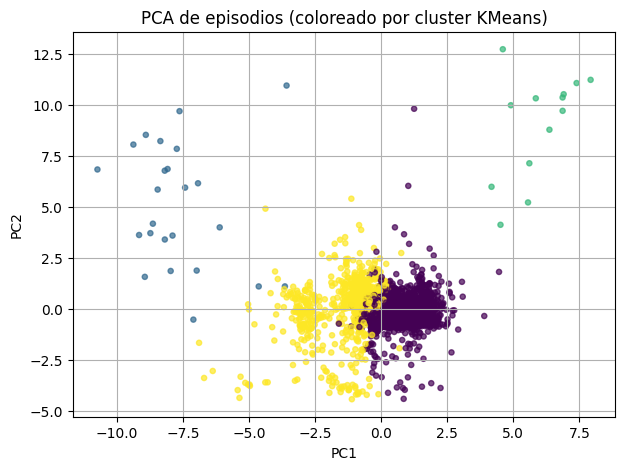

Anomalías detectadas: 42


,start,end,duration_min,tag,max_abs_dP_bar,max_abs_dQ_lps,min_p_g_bar,min_margin_vap_bar,min_sigma_cav,cluster,anomaly
1174,2025-07-15 21:18:00,2025-07-15 21:21:00,3.0,p_g_cerca_cero,1.534427,58.55,0.087024,1.076979,134.447549,1,1
637,2025-04-16 00:30:00,2025-04-16 00:30:00,0.0,P_baja_Q_sube,1.483413,66.84,0.378105,1.368060,170.543299,1,1
1724,2025-10-14 15:45:00,2025-10-14 15:54:00,9.0,otro,1.369381,26.85,0.341095,1.331049,331.023768,1,1
1107,2025-07-03 08:50:00,2025-07-03 08:51:00,1.0,P_baja_Q_sube,1.354377,41.43,0.352098,1.342052,196.235953,1,1
1705,2025-10-11 22:36:00,2025-10-11 22:37:00,1.0,P_sube_Q_baja,1.283357,49.73,1.847514,2.837468,1497.047289,2,1
639,2025-04-16 06:49:00,2025-04-16 06:54:00,5.0,p_g_cerca_cero,1.277355,63.27,0.000000,0.989954,123.533544,1,1
675,2025-04-23 00:48:00,2025-04-23 00:48:00,0.0,P_baja_Q_sube,1.237344,66.09,0.649181,1.639135,204.542922,1,1
1840,2025-10-27 21:22:00,2025-10-27 21:24:00,2.0,p_g_cerca_cero,1.194332,64.86,0.180050,1.170004,146.297896,1,1
1637,2025-10-02 21:46:00,2025-10-02 21:46:00,0.0,P_baja_Q_sube,1.184330,74.31,0.358100,1.348054,168.800982,1,1
1701,2025-10-10 23:01:00,2025-10-10 23:02:00,1.0,P_baja_Q_sube,1.134316,31.47,0.423118,1.413072,177.446544,1,1


In [62]:
if len(feats) == 0:
    print('No hay episodios para ML (revisar umbrales).')
else:
    X_cols = [
        'duration_min',
        'max_abs_dP_bar','max_abs_dQ_lps','max_abs_dV_ms',
        'min_p_g_bar','min_margin_vap_bar','min_sigma_cav',
        'delta_p_g_med','delta_q_med'
    ]

    X = feats[X_cols].replace([np.inf,-np.inf], np.nan).dropna().copy()
    print('Episodios con features completos:', X.shape[0], '/', feats.shape[0])

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X.values)

    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(Xs)

    k = 4
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(Xs)

    iso = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)
    anom = iso.fit_predict(Xs)

    X_out = X.copy()
    X_out['cluster'] = labels
    X_out['anomaly'] = (anom == -1).astype(int)

    feats_ml = feats.join(X_out[['cluster','anomaly']], how='left')

    plt.figure(figsize=(7,5))
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=14, alpha=0.7)
    plt.title('PCA de episodios (coloreado por cluster KMeans)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

    print('Anomalías detectadas:', int((anom == -1).sum()))

    top_anom = feats_ml[feats_ml['anomaly']==1].sort_values('max_abs_dP_bar', ascending=False).head(10)
    display(top_anom[['start','end','duration_min','tag','max_abs_dP_bar','max_abs_dQ_lps','min_p_g_bar',
                      'min_margin_vap_bar','min_sigma_cav','cluster','anomaly']])


## 12) Guardar episodios y features

In [63]:
OUT_EPISODES.parent.mkdir(parents=True, exist_ok=True)
OUT_FEATURES.parent.mkdir(parents=True, exist_ok=True)

episodes.to_parquet(OUT_EPISODES, index=False)

if len(feats) == 0:
    feats.to_parquet(OUT_FEATURES, index=False)
else:
    if 'feats_ml' in globals():
        feats_ml.to_parquet(OUT_FEATURES, index=False)
    else:
        feats.to_parquet(OUT_FEATURES, index=False)

OUT_EPISODES, OUT_FEATURES


(PosixPath('/home/maxi/datascience_esval/data/processed/episodios_hidraulicos.parquet'),
 PosixPath('/home/maxi/datascience_esval/data/processed/features_episodios_hidraulicos.parquet'))

## Resumen (para pegar en el chat)

La siguiente celda imprime un resumen compacto y **autosuficiente** (no depende del orden de ejecución):
- percentiles de $V$
- cavitación (screening)
- percentiles de $|\Delta V|$, $|\Delta P|$, $a_{\mathrm{ef}}$ (proxy)
- conteo de eventos/episodios
- ML (si aplica)


In [64]:
print('=== RESUMEN DATASET (02) ===')

print('\nEntrada:')
print('CLEAN_FILE:', CLEAN_FILE)

print('\nParámetros:')
print('D (m):', D)
print('A (m^2):', float(A))
print('rho_f (kg/m3):', rho_f)
print('P_atm_bar:', P_atm_bar)
print('T_C:', T_C)
print('Pv_bar(T):', Pv_bar)

vv = h[h['is_valid']].copy()

# asegurar derivadas para el resumen
if 'dV_ms' not in vv.columns:
    vv['dQ_m3s'] = vv[dQ_COL] / 1000.0
    vv['dV_ms'] = vv['dQ_m3s'] / A

if 'a_eff_ms' not in vv.columns:
    vv['dP_pa'] = vv[dP_COL] * 1e5
    eps = 1e-6
    mask = vv['dV_ms'].abs() > eps
    vv['a_eff_ms'] = np.where(mask, vv['dP_pa'] / (rho_f * vv['dV_ms']), np.nan)

# asegurar flags de evento
if 'Q_STEP_THR' not in globals():
    Q_STEP_THR = 16.0
if 'P_STEP_THR' not in globals():
    P_STEP_THR = 0.30

if 'evt_any' not in vv.columns:
    vv['evt_qstep'] = vv[dQ_COL].abs() > Q_STEP_THR
    vv['evt_pstep'] = vv[dP_COL].abs() > P_STEP_THR
    vv['evt_any'] = vv['evt_qstep'] | vv['evt_pstep']

print('\nTamaño:')
print('N total grilla:', len(h))
print('N válido:', int(vv.shape[0]))
print('Frac válido:', float(vv.shape[0] / len(h)))

print('\nVelocidad V (m/s) percentiles:')
print(vv['v_ms'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99,0.999]))

print('\nCavitación (screening):')
print('Min p_g_bar:', float(vv['p_g_bar'].min()))
print('Min p_abs_bar:', float(vv['p_abs_bar'].min()))
print('Frac(p_abs < Pv):', float((vv['p_abs_bar'] < vv['pv_bar']).mean()))
print('Margin (p_abs-Pv) [bar] percentiles:')
print(vv['margin_vap_bar'].describe(percentiles=[0.001,0.01,0.05,0.5,0.95,0.99,0.999]))

sig = vv['sigma_cav'].replace([np.inf,-np.inf], np.nan).dropna()
print('Sigma_cav percentiles:')
print(sig.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

print('\nTransientes (proxy 1-min):')
print('|dV| (m/s por min) percentiles:')
print(vv['dV_ms'].abs().dropna().describe(percentiles=[0.9,0.95,0.99,0.999]))
print('|dP| (bar por min) percentiles:')
print(vv[dP_COL].abs().dropna().describe(percentiles=[0.9,0.95,0.99,0.999]))

a = vv['a_eff_ms'].replace([np.inf,-np.inf], np.nan).dropna()
a = a[(a.abs() < 5000)]
print('a_eff (m/s) [proxy] percentiles:')
print(a.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

print('\nEventos/episodios:')
print('Umbrales: Q_STEP_THR=', Q_STEP_THR, 'L/s por min | P_STEP_THR=', P_STEP_THR, 'bar por min')
print('n evt_any:', int(vv['evt_any'].sum()))

# cargar outputs si no existen en memoria
import pandas as _pd
if 'episodes' not in globals():
    episodes = _pd.read_parquet(OUT_EPISODES) if OUT_EPISODES.exists() else _pd.DataFrame(columns=['episode_id','start','end','duration_min'])
if 'feats' not in globals():
    feats = _pd.read_parquet(OUT_FEATURES) if OUT_FEATURES.exists() else _pd.DataFrame()

print('n_episodios:', int(len(episodes)))
if len(feats):
    print('\nTop 5 episodios por max_abs_dP:')
    display(feats.sort_values('max_abs_dP_bar', ascending=False).head(5)[
        ['start','end','duration_min','tag','max_abs_dP_bar','max_abs_dQ_lps','min_p_g_bar','min_margin_vap_bar','min_sigma_cav']
    ])
    if 'cluster' in feats.columns and 'anomaly' in feats.columns:
        print('\nML:')
        print('Clusters:', feats['cluster'].value_counts(dropna=True).to_dict())
        print('Anomalías:', int(feats['anomaly'].fillna(0).sum()))

print('\nSalidas:')
print('OUT_EPISODES:', OUT_EPISODES)
print('OUT_FEATURES:', OUT_FEATURES)

print('=== FIN ===')


=== RESUMEN DATASET (02) ===

Entrada:
CLEAN_FILE: /home/maxi/datascience_esval/data/processed/sensores_1min_clean.parquet

Parámetros:
D (m): 0.315
A (m^2): 0.07793113276311181
rho_f (kg/m3): 1000.0
P_atm_bar: 1.01325
T_C: 20.0
Pv_bar(T): 0.023295689144226493

Tamaño:
N total grilla: 475201
N válido: 462130
Frac válido: 0.9724937447522206

Velocidad V (m/s) percentiles:
count    462130.000000
mean          0.635147
std           0.250680
min           0.000000
1%            0.215190
5%            0.247270
50%           0.644030
95%           1.029755
99%           1.148065
99.9%         1.262782
max           1.270352
Name: v_ms, dtype: float64

Cavitación (screening):
Min p_g_bar: 0.0
Min p_abs_bar: 1.01325
Frac(p_abs < Pv): 0.0
Margin (p_abs-Pv) [bar] percentiles:
count    462130.000000
mean          2.453230
std           0.264075
min           0.989954
0.1%          1.268161
1%            1.907210
5%            1.961225
50%           2.510377
95%           2.819463
99%           2

,start,end,duration_min,tag,max_abs_dP_bar,max_abs_dQ_lps,min_p_g_bar,min_margin_vap_bar,min_sigma_cav
1174,2025-07-15 21:18:00,2025-07-15 21:21:00,3.0,p_g_cerca_cero,1.534427,58.55,0.087024,1.076979,134.447549
637,2025-04-16 00:30:00,2025-04-16 00:30:00,0.0,P_baja_Q_sube,1.483413,66.84,0.378105,1.368060,170.543299
1724,2025-10-14 15:45:00,2025-10-14 15:54:00,9.0,otro,1.369381,26.85,0.341095,1.331049,331.023768
1107,2025-07-03 08:50:00,2025-07-03 08:51:00,1.0,P_baja_Q_sube,1.354377,41.43,0.352098,1.342052,196.235953
1705,2025-10-11 22:36:00,2025-10-11 22:37:00,1.0,P_sube_Q_baja,1.283357,49.73,1.847514,2.837468,1497.047289



Salidas:
OUT_EPISODES: /home/maxi/datascience_esval/data/processed/episodios_hidraulicos.parquet
OUT_FEATURES: /home/maxi/datascience_esval/data/processed/features_episodios_hidraulicos.parquet
=== FIN ===
